In [32]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt

## Cargamos la data 

El dataset Fashion-MNIST cotiene 60,00 imagenes para el set de datos de entrenamiento y un set de datos de prueba de 10,000.

In [33]:
fashion_mnist = keras.datasets.fashion_mnist

In [34]:
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

## Imagenes
Las imagenes son Numpy Arrays de 28x28, los pixeles estan entre los valores de 0 a 255

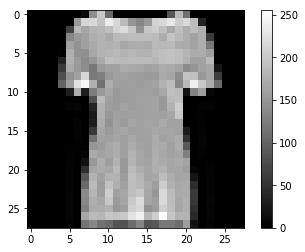

In [7]:
plt.imshow(train_images[10], cmap = 'gray')
plt.colorbar()

## Labels

In [8]:
np.unique(train_labels)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

| Label | Class       |
|-------|-------------|
| 0     | T-shirt/top |
| 1     | Trouser     |
| 2     | Pullover    |
| 3     | Dress       |
| 4     | Coat        |
| 5     | Sandal      |
| 6     | Shirt       |
| 7     | Sneaker     |
| 8     | Bag         |
| 9     | Ankle boot  |

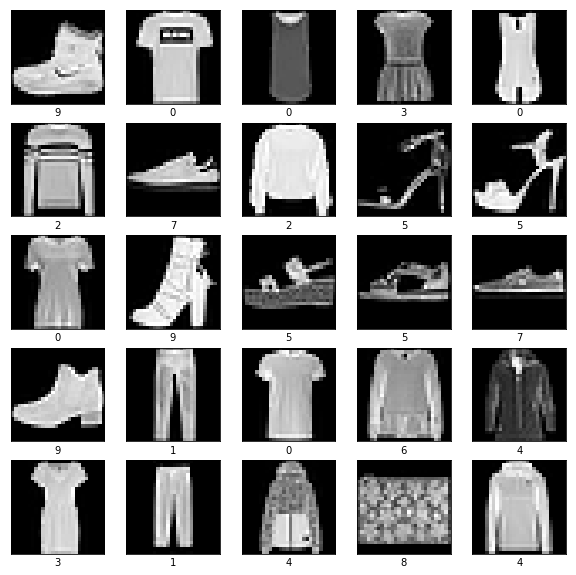

In [9]:
plt.figure(figsize=(10,10))

for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap='gray')
    plt.xlabel(train_labels[i])
plt.show()

# Tarea

Para esta tarea se deben utilizar únicamente 3 clases, se puede escoger cualquiera de las 10 disponibles en el data set, por lo que hay que filtrar las clases elegidas en los arreglos:
- train_images
- train_labels
- test_images
- test_labels

El objetivo de la tarea es comparar la diferencia al aplicar feature scale/normalization y las features sin ninguna transformación y comparar el efecto de el scaling/normalización sobre el entrenamiento con regresión logística.
- Se debe crear un diccionario con el valor numérico de las labels y el texto correspondiente para poder relacionar el valor numérico con el valor descriptivo/textual.
- Aplicar regresión logística con entropía cruzada como función de costo, crear una función que recibe de entrada un tensor x y predice la clase(utilizar el diccionario para mostrar el texto perteneciente al label).
- Adicional a el costo(por entropía cruzada) en el grafo se debe agregar un nodo que calcule el acurracy(comparando el valor real vs el estimado por el modelo).
- El accuracy y el costo deben ser agregados a tensorboard(agregar screenshots al notebook)
- Se debe agregar al notebook un screenshot del grafo/grafos de tensorboard, simplificando(usando names y name_scope como visto en clase).
- Todo lo anterior se debe hacer tanto para datos crudos, como para datos transformados con (normalización y escalado)
- Basado en los ejemplos de visualización de imagenes en el notebook ,crear una función que reciba de entrada el tensor que representa a una imagen, grafique esta imagen poniendo como título el nombre de la prenda con mayor probabilidad.
- Utilizar la función anterior para mostrar una muestra aleatoria de 5 imágenes(y la predicción probabilistica de la prenda)
- Comparar con tensorboard las curvas de aprendizaje del entrenamiento con datos crudos vs datos transformados, y los 2 grafos y concluir/opinar al respecto usando markdown(agregando screenshots)
- Utilizar mini batch gradient descent con batch size de 32

***
## Resize
Realizando el resize de las imagenes con las categorias seleccionadas

In [10]:
# Se escogen las tres categorias
categorias = np.array([2,7,9])
# Indices de las categorias seleccionadas
index_train = np.where((train_labels == categorias[0])|(train_labels == categorias[1])|(train_labels == categorias[2]))
index_test = np.where((test_labels == categorias[0])|(test_labels == categorias[1])|(test_labels == categorias[2]))

# Resize de las imagenes de entrenamiento y las de prueba
r_train_images = np.copy(train_images[index_train])
r_test_images = np.copy(test_images[index_test])

train_shape = r_train_images.shape
test_shape = r_test_images.shape

r_train_images.resize((train_shape[0], train_shape[1]*train_shape[2]))
print(r_train_images.shape)
r_test_images.resize((test_shape[0], test_shape[1]*test_shape[2]))
print(r_test_images.shape)

(18000, 784)
(3000, 784)


## Onehot Encoding para las label

In [11]:
# Se realiza onehot encoding a las etiquetas
from sklearn.preprocessing import LabelEncoder

labelencoder = LabelEncoder()
labels = np.copy(categorias)
categorias = labelencoder.fit_transform(train_labels[index_train])
train_y = np.eye(len(set(train_labels[index_train])))[categorias]

labels = np.copy(categorias)
categorias = labelencoder.fit_transform(test_labels[index_test])
test_y = np.eye(len(set(test_labels[index_test])))[categorias]

num_test = test_y.shape[0]

print(train_y.shape)
print(test_y.shape)

(18000, 3)
(3000, 3)


***
## Construcción del grafo y sesión

In [12]:
tf.reset_default_graph()
grafo = tf.Graph()
with grafo.as_default() as g:
    X = tf.placeholder("float", shape = [None, 784], name = "X_train")
    Y = tf.placeholder("float", shape = [None, 3], name = "Y_train")
    #W = tf.Variable(tf.random_uniform([784,3]), dtype = "float", name = "W")
    W = tf.Variable(tf.zeros([784, 3]), name = "W", dtype = "float")
    b = tf.Variable(tf.zeros([3]), name = "b", dtype = "float")
    learning_rate = tf.placeholder("float", name = "learning_rate")
    with tf.name_scope('Mult') as scope:
        mul = tf.add(tf.matmul(X, W), b)
    with tf.name_scope('Softmax') as scope:
        soft = tf.nn.softmax(mul, name = "Softmax")
    with tf.name_scope('Entropia_Cruzada') as scope:
        #cost = tf.reduce_mean(-tf.reduce_sum(Y*tf.log(soft), reduction_indices = 1))
        cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=Y, logits=soft))
        cost_summary = tf.summary.scalar("cost", cost)
        optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)
    with tf.name_scope("Prediccion") as scope:
        pred = tf.equal(tf.argmax(soft,1), tf.argmax(Y,1))
    with tf.name_scope("Accuracy") as scope:
        accuracy = tf.reduce_mean(tf.cast(pred, "float"))
        accuracy_summary = tf.summary.scalar('Accuracy', accuracy)
    group_summ = tf.summary.merge_all()
    init = tf.global_variables_initializer()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [26]:
def entrenamiento(data_x, data_y, lr, t_epoch, batch_size, display_epoch, name):
    num_train = data_y.shape[0]
    t_batch = num_train//batch_size
        
    with tf.Session(graph = grafo) as sess:
        writer = tf.summary.FileWriter('./graphs/lr_prueba_'+name, sess.graph)
        sess.run(init)
        for epoch in range(t_epoch):
            #optimizacion = sess.run(cost, feed_dict = {X: data_x, Y: data_y})
            resultado_costo = 0
            for bt in range(t_batch):
                batch_x = data_x[bt*batch_size:bt*batch_size+batch_size]
                batch_y = data_y[bt*batch_size:bt*batch_size+batch_size]
                sess.run(optimizer, feed_dict = {X: batch_x, Y: batch_y, learning_rate: lr})
            if (epoch + 1) % display_epoch == 0:
                training_cost, weight, bias, acc = sess.run([cost, W, b, accuracy], feed_dict = {X: batch_x, Y: batch_y, learning_rate: lr})
                s = sess.run(group_summ, feed_dict = {X: batch_x, Y: batch_y, learning_rate: lr})
                writer.add_summary(s, epoch+1)
                print("Epoch: ", (epoch + 1))
                print("Costo: ", training_cost)
                print("W: ", weight)
                print("b: ", bias)
                print("Accuracy: ", acc)
                print("----------------------------------------------")
        writer.close()
        return(weight, bias)
        

***
## Entrenamiento data sin normalizar

In [27]:
result_w, result_b = entrenamiento(r_train_images, train_y, 0.001, 100, 32, 20, "sin_normalizar")

Epoch:  20
Costo:  0.61394465
W:  [[ 0.0000000e+00  0.0000000e+00 -1.3520742e-24]
 [ 1.3100394e-06 -1.7029994e-24 -1.3100411e-06]
 [ 8.2648567e-06 -3.4722223e-06 -4.7926364e-06]
 ...
 [ 1.3519375e-03 -6.4010656e-04 -7.1183132e-04]
 [ 6.9973140e-04 -2.0716222e-06 -6.9766026e-04]
 [ 5.4155851e-05 -5.0310820e-07 -5.3652813e-05]]
b:  [ 3.3874701e-05  4.0938746e-04 -4.4326248e-04]
Accuracy:  0.9375
----------------------------------------------
Epoch:  40
Costo:  0.64519465
W:  [[ 0.0000000e+00  0.0000000e+00 -1.8264725e-20]
 [ 1.4165503e-06 -1.7029994e-24 -1.4165510e-06]
 [ 8.4110397e-06 -3.4722223e-06 -4.9388200e-06]
 ...
 [ 1.4042148e-03 -6.4923370e-04 -7.5498113e-04]
 [ 7.4020214e-04 -2.3606872e-06 -7.3784176e-04]
 [ 5.6605601e-05 -5.0310820e-07 -5.6102541e-05]]
b:  [ 4.7631223e-05  7.1000837e-04 -7.5763965e-04]
Accuracy:  0.90625
----------------------------------------------
Epoch:  60
Costo:  0.61394465
W:  [[ 0.0000000e+00  0.0000000e+00 -1.8264730e-20]
 [ 1.4165503e-06 -1.7029994e-

In [28]:
print(result_w)
print(result_b)

[[ 0.0000000e+00  0.0000000e+00 -1.8279380e-20]
 [ 2.2499096e-06 -1.7029994e-24 -2.2499094e-06]
 [ 9.2520204e-06 -3.4722223e-06 -5.7797774e-06]
 ...
 [ 2.1071006e-03 -8.0524373e-04 -1.3018573e-03]
 [ 9.2018873e-04 -1.4282342e-04 -7.7736576e-04]
 [ 7.5772863e-05 -5.0310820e-07 -7.5269782e-05]]
[ 6.4837091e-05  1.4038375e-03 -1.4686732e-03]


***
## Entrenamiento data normalizada

In [29]:
result_n_w, result_n_b = entrenamiento(r_train_images/255, train_y, 0.001, 100, 32, 20, "normalizada")

Epoch:  20
Costo:  0.6692361
W:  [[ 4.1639746e-07 -1.2613806e-07 -2.9025938e-07]
 [ 5.3587664e-06 -4.0080822e-06 -1.3506833e-06]
 [ 4.8164689e-05 -2.0864369e-05 -2.7300310e-05]
 ...
 [ 1.2187564e-03 -2.0162750e-03  7.9752214e-04]
 [-1.3448394e-04 -6.4152776e-04  7.7601179e-04]
 [ 3.3687265e-05 -7.9964768e-05  4.6277495e-05]]
b:  [-0.00053477  0.07339377 -0.0728588 ]
Accuracy:  0.875
----------------------------------------------
Epoch:  40
Costo:  0.66120934
W:  [[ 6.8600713e-07 -1.8944932e-07 -4.9655785e-07]
 [ 8.0991958e-06 -5.2054770e-06 -2.8937195e-06]
 [ 8.1231337e-05 -3.3964436e-05 -4.7266618e-05]
 ...
 [ 1.5907580e-03 -2.4710807e-03  8.8032952e-04]
 [-3.9423619e-05 -8.2079286e-04  8.6021557e-04]
 [ 6.4363427e-05 -1.1124088e-04  4.6877394e-05]]
b:  [ 0.00722197  0.1035059  -0.11072704]
Accuracy:  0.875
----------------------------------------------
Epoch:  60
Costo:  0.6567388
W:  [[ 8.9637746e-07 -2.3386123e-07 -6.6251630e-07]
 [ 1.0171974e-05 -6.0294174e-06 -4.1425656e-06]
 [ 1

In [19]:
print(result_n_w)
print(result_n_b)

[[ 1.2244637e-06 -2.9712729e-07 -9.2733677e-07]
 [ 1.3420824e-05 -7.2201274e-06 -6.2007084e-06]
 [ 1.6181030e-04 -6.1882529e-05 -9.9926874e-05]
 ...
 [ 2.2988056e-03 -3.2984717e-03  9.9973567e-04]
 [ 1.7338083e-04 -1.1891561e-03  1.0157935e-03]
 [ 1.2850270e-04 -1.7399482e-04  4.5492463e-05]]
[ 0.02167668  0.16970456 -0.19138035]


***
## Función prediccion

In [20]:
t_images = test_images[index_test]
t_labels = test_labels[index_test]

def prediccion(r_w, r_b, data_x, num_imagen):
    categorias = np.array(["2 - Pullover","7 - Sneaker","9 - Ankle boot"])
    mul = np.matmul(data_x[num_imagen], r_w)+r_b
    soft = np.exp(mul-np.max(mul))/np.sum(np.exp(mul-np.max(mul)))
    categoria = np.argmax(soft)
    print("Categoria: ",categorias[categoria])
    print("Probabilidad: ",soft[categoria])

***
## Predicciones data sin normalizar
Se utilizan únicamente las imagenes de las 3 categorias seleccionadas

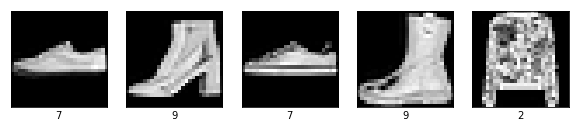

Categoria:  7 - Sneaker
Probabilidad:  1.0
Categoria:  9 - Ankle boot
Probabilidad:  1.0
Categoria:  7 - Sneaker
Probabilidad:  1.0
Categoria:  9 - Ankle boot
Probabilidad:  1.0
Categoria:  2 - Pullover
Probabilidad:  1.0


In [25]:
random = np.random.randint(low = 0, high = r_test_images.shape[0], size = 5)
plt.figure(figsize=(10,10))
for i in range(len(random)):
    plt.subplot(1,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(t_images[random[i]], cmap='gray')
    plt.xlabel(t_labels[random[i]])
plt.show()


for x in random:
    prediccion(result_w, result_b, r_test_images, x)

***
## Predicciones data normalizada
Se utilizan únicamente las imagenes de las 3 categorias seleccionadas

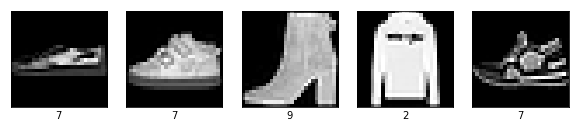

Categoria:  7 - Sneaker
Probabilidad:  0.9890379985043332
Categoria:  7 - Sneaker
Probabilidad:  0.9901167505818362
Categoria:  9 - Ankle boot
Probabilidad:  0.9990529297251594
Categoria:  2 - Pullover
Probabilidad:  0.9999967930516683
Categoria:  9 - Ankle boot
Probabilidad:  0.5576542444504211


In [23]:
random = np.random.randint(low = 0, high = r_test_images.shape[0], size = 5)
plt.figure(figsize=(10,10))
for i in range(len(random)):
    plt.subplot(1,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(t_images[random[i]], cmap='gray')
    plt.xlabel(t_labels[random[i]])
plt.show()


for x in random:
    prediccion(result_n_w, result_n_b, r_test_images/255, x)

***
## Utilizando más categorias

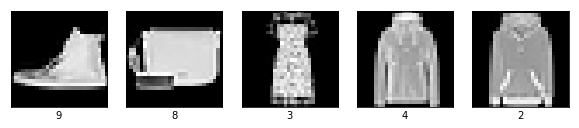

Categoria:  9 - Ankle boot
Probabilidad:  0.9918395347789746
Categoria:  7 - Sneaker
Probabilidad:  0.6215833711542714
Categoria:  2 - Pullover
Probabilidad:  0.8432067470103909
Categoria:  2 - Pullover
Probabilidad:  0.9997718776202806
Categoria:  2 - Pullover
Probabilidad:  0.9997552389782719


In [42]:
test_images_reshape = np.copy(test_images)
test_shape = test_images_reshape.shape

test_images_reshape.resize((test_shape[0], test_shape[1]*test_shape[2]))

random = np.random.randint(low = 0, high = test_images_reshape.shape[0], size = 5)
plt.figure(figsize=(10,10))
for i in range(len(random)):
    plt.subplot(1,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(test_images[random[i]], cmap='gray')
    plt.xlabel(test_labels[random[i]])
plt.show()


for x in random:
    prediccion(result_n_w, result_n_b, test_images_reshape/255, x)

***
# Grafo

<img src = "https://i.pinimg.com/564x/0e/1d/91/0e1d915b515f5b21fa9ef17c6827537e.jpg">

<img src = "https://i.pinimg.com/564x/bd/58/54/bd58540fc3cded2287d10a043e47735d.jpg">

<img src = "https://i.pinimg.com/originals/51/62/c1/5162c104c52affb88eb0a2001c600d65.png">

<img src = "https://i.pinimg.com/564x/17/30/97/1730971277e147bb855cc2aeca34c6df.jpg">

***
# Conclusiones

* Se puede apreciar en las gráficas de costo y accuracy que al tener la data normalizada esta tiende a reducir el costo y mantenerlo estable.
* Al comparar el modelo entrenado para las tres categorias (2, 7, 9) y este es aplicado a las demás categorías del data set trata de predecir su clasificación (siempre se ven porcentajes de probabilidad bajos para la categoria más adecuada0